# COMSOL Simulation: Mesh refinement for the simulation of the emitting spot size

- Original datafile in: /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data

- Settings in COMSOL were: -100 kV, 1mA ion beam current


### lookup table


In [4]:
lut = pd.DataFrame({'case': ['001', '002', '003', '004'], 'ts': ['2e-8', '2e-9', '2e-10', '2e-11']})
lut_mesh = pd.DataFrame({'case': ['001', '002', '003', '004'], 'num_mesh': [3813903, 833076, 669145, 5548774]})
lut_mesh.head()

,case,num_mesh
0,001,3813903
1,002,833076
2,003,669145
3,004,5548774


## Time stepping refinement for 3813903 mesh elements

In [5]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import kde
from scipy import optimize
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

pd.set_option("display.max_columns", 300)


# filename for the data
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/'

# load the data if it contains "normE" in its name
files = os.listdir(folder)
files = [f for f in files if "hmesh" not in f]
files = [f'{folder}/{f}' for f in files if "normE" in f]
colors = ['darkred', 'darkblue', 'darkorange']

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


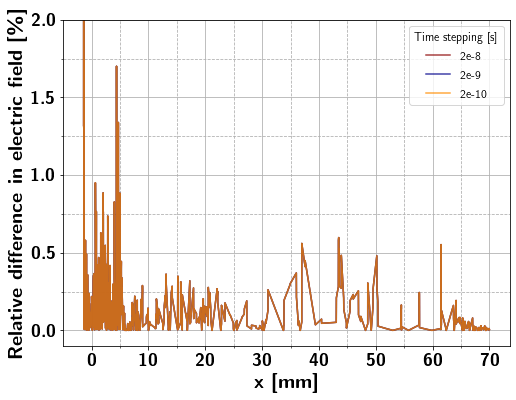

In [6]:
# compute relative differences for y=z=0
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/temporal_resolution'
figname = 'MR_temporal'
dfs = [] # list of the dataframes
for fname in files:
    case = re.findall(r'refinement\.(\d\d\d)\.', fname)[0]
    data = pd.read_csv(fname, skiprows=8)
    data.columns = ['x', 'y', 'z', 'E']
    data['case'] = case
    ts = lut['ts'][ lut['case'] == case ].values[0]
#     print(ts)
    data['ts'] = ts
    if case == '004':
        ref_df = data
    else:
        dfs.append(data)
        
ref_data = ref_df[ (ref_df['y']==0) & (ref_df['z']==0) ]
ref_data.sort_values(by=['x'],ascending=True)
out_data = ref_data.set_index('x')       
for df in dfs:
    data = df[ (df['y']==0) & (df['z']==0) ]
    data.sort_values(by=['x'],ascending=True)
    ts = data['ts'].values[0]
    case = data['case'].values[0]

    ref_data = ref_df[ (ref_df['y']==0) & (ref_df['z']==0) ]
    ref_data.sort_values(by=['x'],ascending=True)

    assert np.max(np.abs(ref_data['x']-data['x'])) == 0 

    X = ref_data['x'].values

    ref_E = ref_data['E'].values
    data_E = data['E'].values
    Y_diff = np.abs(ref_E-data_E)  # difference
    Y = np.abs((Y_diff)/ref_E)*100 # in percent

    # add to the ref_dataframe
    ref_data[f'E_diff_{case}'] = Y
    ref_data.set_index('x', inplace=True)
    out_data[f'E_diff_{case}'] = Y  
    

fs = 20
ii = 0
fig = plt.figure(1, figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
for case in lut['case'].values:
    # do not do the reference
    if case is not '004':
        cols = [c for c in out_data.columns if 'E_diff' in c]
        col = [c for c in cols if case in c]
        assert len(col) == 1
        X = out_data.index.values
#         X = X[::100]
        Y = out_data[col[0]].values
#         Y = Y[::100]
        ts = lut['ts'][ lut['case'] == case ].values[0]
        plt.plot(X, Y, linewidth=1.5,label=ts,alpha=0.75,color=colors[ii])
        ii = ii + 1
        
plt.xlabel(r'\textbf{x [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Relative difference in electric field [\%]}', fontsize=fs)
    
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')     
ylims = ax1.get_ylim()
plt.yticks(np.arange(0,2.5,0.5))
plt.ylim(-0.1,2)
leg1 = plt.legend(loc="best",  fontsize=12)
leg1.set_title(r"Time stepping [s]", prop = {'size': 12})
plt.savefig(f'{outfolder}/{figname}.pdf')
plt.show()

In [7]:
out_data.head()

,y,z,E,case,ts,E_diff_001,E_diff_003,E_diff_002
x,,,,,,,,
-1.400,0.0,0.0,125900.789856,004,2e-11,1.319730,1.310966,1.317848
-1.395,0.0,0.0,129336.457155,004,2e-11,11.991998,11.991915,11.991486
-1.390,0.0,0.0,132779.572107,004,2e-11,9.124154,9.124078,9.123667
-1.385,0.0,0.0,136229.570007,004,2e-11,6.403503,6.403434,6.403029
-1.380,0.0,0.0,139685.940868,004,2e-11,3.821248,3.821188,3.820785


In [8]:
cols = out_data.columns
out_data = out_data[ out_data.index > -1.4 ]
ref_data = ref_data[ ref_data.index > -1.4 ]
cols = [c for c in cols if "E_" in c]

df_NRMSD = pd.DataFrame(ref_data['E'])

# loop through each case
for case in lut['case'].values:
    # do not do the reference
    if case is not '004':
        # select that case dataframe
        this_cols = [c for c in cols if case in c]
        assert len(this_cols) == 9 # number of measurements at each x is 9
        data = out_data[this_cols]
        # compute RMSD as sqrt(E_diff^2/n) for each x, where n is the number of measurements (9)
        RMSD = np.sqrt(((data.sum(axis=1)**2)/9))
        # compute difference between maximum and minimum E_diff E_{case}_max for each x
        y_hat = np.abs(data.max(axis=1)-data.min(axis=1))  
        # normalized RMSD
        NRMSD = RMSD/y_hat
        data[f'RMSD_{case}'] = RMSD
        data[f'y_hat_{case}'] = y_hat
        data[f'NRMSD_{case}'] = NRMSD

        df_NRMSD[f'RMSD_{case}'] = RMSD
        df_NRMSD[f'y_hat_{case}'] = y_hat
        df_NRMSD[f'NRMSD_{case}'] = NRMSD

fs = 20

fig = plt.figure(1, figsize=(10, 9))
ax1 = fig.add_subplot(1, 1, 1)
for case in lut['case'].values:
    # do not do the reference
    if case is not '004':
        cols = [c for c in df_NRMSD.columns if 'NRMSD' in c]
        col = [c for c in cols if case in c]
        assert len(col) == 1
        X = df_NRMSD.index.values
        Y = df_NRMSD[col[0]].values
        plt.plot(X, Y, label=case)
        
plt.xlabel(r'\textbf{x [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{NRMSD [-]}', fontsize=fs)
    
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')     

plt.legend()
plt.show()

AssertionError: 

## Mesh number refinement for time stepping 2e-10

In [9]:
# load the data if it contains "normE" in its name
files = os.listdir(folder)
files = [f for f in files if "hmesh" in f]
files = [f'{folder}/{f}' for f in files if "normE" in f]
files.append('/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.003.normE.csv')
files

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.003.hmesh.003.normE.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.003.hmesh.002.normE.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.003.hmesh.004.normE.csv',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data//02.MR.102.temporal_refinement.003.normE.csv']

In [10]:
lut_mesh

,case,num_mesh
0,001,3813903
1,002,833076
2,003,669145
3,004,5548774


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['E_diff_003', 'E_diff_002', 'E_diff_001']
['E_diff_003', 'E_diff_002', 'E_diff_001']
['E_diff_003', 'E_diff_002', 'E_diff_001']


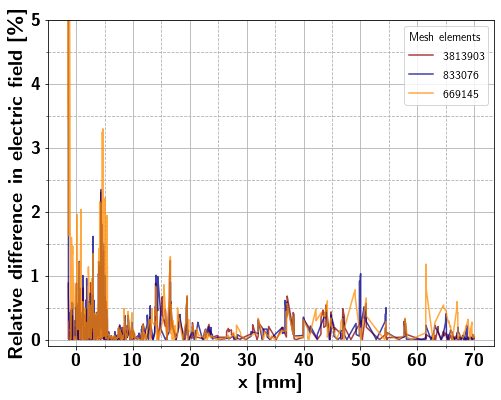

In [11]:
# compute relative differences for y=z=0
outfolder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/02.current_chamber/02.MR/temporal_refinement/data/number_of_mesh_elements'
figname = 'MR_numb_elements'
dfs = [] # list of the dataframes
for fname in files:
    case = re.findall(r'hmesh\.(\d\d\d)\.', fname)
    if len(case) > 0:
        case = case[0]
    else:
        case = '001' # reference case
    data = pd.read_csv(fname, skiprows=8)
    data.columns = ['x', 'y', 'z', 'E']
    data['case'] = case
    num_mesh = lut_mesh['num_mesh'][ lut_mesh['case'] == case ].values[0]
#     print(ts)
    data['num_mesh'] = num_mesh
    if case == '004':
        ref_df = data
    else:
        dfs.append(data)

        
ref_data = ref_df[ (ref_df['y']==0) & (ref_df['z']==0) ]
ref_data.sort_values(by=['x'],ascending=True)
out_data = ref_data.set_index('x')       
for df in dfs:
    data = df[ (df['y']==0) & (df['z']==0) ]
    data.sort_values(by=['x'],ascending=True)
    num_mesh = data['num_mesh'].values[0]
    case = data['case'].values[0]

    ref_data = ref_df[ (ref_df['y']==0) & (ref_df['z']==0) ]
    ref_data.sort_values(by=['x'],ascending=True)

    assert np.max(np.abs(ref_data['x']-data['x'])) == 0 

    X = ref_data['x'].values

    ref_E = ref_data['E'].values
    data_E = data['E'].values
    Y_diff = np.abs(ref_E-data_E)  # difference
    Y = np.abs((Y_diff)/ref_E)*100 # in percent

    # add to the ref_dataframe
    ref_data[f'E_diff_{case}'] = Y
    ref_data.set_index('x', inplace=True)
    out_data[f'E_diff_{case}'] = Y  
    

fs = 20
ii = 0 
fig = plt.figure(1, figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
for case in lut_mesh['case'].values:
    # do not do the reference
    if case is not '004':
        cols = [c for c in out_data.columns if 'E_diff' in c]
        col = [c for c in cols if case in c]
        print(cols)
        assert len(col) == 1
        X = out_data.index.values
#         X = X[::100]
        Y = out_data[col[0]].values
#         Y = Y[::100]
        num_mesh = lut_mesh['num_mesh'][ lut_mesh['case'] == case ].values[0]
        plt.plot(X, Y, linewidth=1.5,label=num_mesh,alpha=0.75, color=colors[ii])
        ii = ii + 1
        
plt.xlabel(r'\textbf{x [mm]}', fontsize=fs)
plt.ylabel(r'\textbf{Relative difference in electric field [\%]}', fontsize=fs)
    
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

ax1.tick_params('x', colors='black', labelsize=fs-2)
ax1.tick_params('y', colors='black', labelsize=fs-2)

ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')     
# ylims = ax1.get_ylim()
# plt.yticks(np.arange(0,2.5,0.5))
plt.ylim(-0.1,5)
leg1 = plt.legend(loc="best",  fontsize=12)
leg1.set_title(r"Mesh elements", prop = {'size': 12})
plt.savefig(f'{outfolder}/{figname}.pdf')
plt.show()